# TODO

Exploratory Data Analysis
- [X] Maybe make a pairplot?
- [ ] [Camila] Compute and plot the correlation between features
- [ ] [Camila] Analyze Null values -> There are none, but we need to write about it
- [ ] [Camila] Check outliers
- [ ] [Camila] Take care of the Lat/Long variables (how are we going to use them?)

Pre-Modeling
- [X] Split the data into train and test
- [X] Decide what are our target variable(s)
- [X] Create the grid search for hyper parameter optimization and model selection
- [ ] Apply PCA to see if we can benefit from it (Low prio)

Modeling
- [ ] [Dio] Check Feature Selection
- [ ] Try to build a classifier (Low prio)
- [ ] [Dio] Feature Importance

Post-modeling
- [ ] [Camila] Plot residuals

# Airbnb: Amsterdam x Paris

In [1]:
# !pip install ydata_profiling ipywidgets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from ydata_profiling import ProfileReport

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import pipeline
from sklearn import ensemble
from sklearn import compose

In [3]:
SEED = 13
TEST_DATASET_RATIO = 0.3
RAW_DATA_PATH = '../raw_data'
DTYPES = {
    'realSum':                    'float64',
    'room_type':                  'category',  # Three possible categories: ['Entire home/apt', 'Private room', 'Shared room']
    'room_shared':                'bool',
    'room_private':               'bool',
    'person_capacity':            'int8',
    'host_is_superhost':          'bool',
    'multi':                      'bool',  # multi seems to be a boolean variable.
    'biz':                        'bool',  # biz seems to be a boolean variable.
    'cleanliness_rating':         'int8',
    'guest_satisfaction_overall': 'int16',
    'bedrooms':                   'int8',
    'dist':                       'float64',
    'metro_dist':                 'float64',
    'attr_index':                 'float64',
    'attr_index_norm':            'float64',
    'rest_index':                 'float64',
    'rest_index_norm':            'float64',
    'lng':                        'float64',
    'lat':                        'float64'
}

In [4]:
def _read_csv(path: str) -> pd.DataFrame:
    """
    Helper function to read csv's, set their index properly and convert the datatypes here accordingly.
    Many times the automatic detection was using Int64 for variables with a small range of values (like `person_capacity`),
    using integeres instead of booleans (for `multi` and `biz`) or not using the categorical datatype (`room_type`).
    """
    return pd.read_csv(
        path,
        index_col=0,
        dtype=DTYPES
    )


def _read_city(city: str) -> pd.DataFrame:
    """
    Helper function to generate a merged dataframe for a specified @city.
    It combines the weekdays and the weekends data into a single dataframe.
    """
    assert city in ['amsterdam', 'paris'], "ERROR: Invalid city. Options are 'amsterdam' or 'paris'"
    
    weekday_path = f"{RAW_DATA_PATH}/{city}_weekdays.csv"
    weekday = _read_csv(weekday_path)
    weekday['is_weekend'] = False

    weekend_path = f"{RAW_DATA_PATH}/{city}_weekends.csv"
    weekend = _read_csv(weekend_path)
    weekend['is_weekend'] = True

    merged = pd.concat([weekday, weekend])
    merged['city'] = city

    return merged.reset_index(drop=True)


def get_merged_df() -> pd.DataFrame:
    """
    Reads the data from both files (weekends and weekdays) and both cities (Amsterdam and Paris) and merge them into a single dataframe.
    It also corrects the datatypes and sets the index properly.
    """
    amsterdam = _read_city('amsterdam')
    paris = _read_city('paris')
    
    merged = pd.concat([amsterdam, paris])
    merged = merged.reset_index(drop=True)
    merged['city'] = merged['city'].astype("category")
    
    return merged

In [5]:
merged_df = get_merged_df()
merged_df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,is_weekend,city
0,194.033698,Private room,False,True,2,False,True,False,10,93,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,False,amsterdam
1,344.245776,Private room,False,True,4,False,False,False,8,85,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,False,amsterdam
2,264.101422,Private room,False,True,2,False,False,True,9,87,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,False,amsterdam
3,433.529398,Private room,False,True,4,False,False,True,9,90,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,False,amsterdam
4,485.552926,Private room,False,True,2,True,False,False,10,98,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,False,amsterdam


## Notes
I am stratifying the train-test split by `city` and by `is_weekend`.

## Train Test Split

In [6]:
X = merged_df.drop('realSum', axis=1)
y = merged_df['realSum']

In [7]:
stratify_col = 2 * preprocessing.LabelEncoder().fit_transform(X['city']) + preprocessing.LabelEncoder().fit_transform(X['is_weekend'])

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=TEST_DATASET_RATIO,
    random_state=SEED,
    shuffle=True,
    stratify=stratify_col
)

In [9]:
y_train

5367    339.500419
5355    324.354553
5607    316.199087
5239    486.531830
4545    669.913319
           ...    
1859    276.287114
7862    227.654022
6599    356.976419
1913    448.527172
4808    237.207568
Name: realSum, Length: 6137, dtype: float64

In [10]:
X_train

,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,is_weekend,city
5367,Entire home/apt,False,False,2,False,False,True,9,95,0,0.883243,0.184813,459.562517,22.346261,1114.340004,51.407103,2.35700,48.86400,True,paris
5355,Private room,False,True,3,False,False,True,9,89,2,1.189804,0.185527,731.393669,35.564070,1588.161245,73.265581,2.33700,48.85400,True,paris
5607,Entire home/apt,False,False,4,False,False,True,9,88,1,0.820219,0.350694,489.655080,23.809514,1053.609050,48.605442,2.36247,48.86021,True,paris
5239,Entire home/apt,False,False,4,False,False,False,9,95,0,0.321040,0.312985,778.098033,37.835073,1181.983859,54.527671,2.35327,48.85370,True,paris
4545,Private room,False,True,4,False,False,False,10,100,1,5.288413,0.380616,364.491874,17.743342,565.843654,33.248711,2.28068,48.85790,False,paris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,Private room,False,True,2,False,False,False,10,80,1,4.199364,3.033310,92.990260,4.923408,117.525496,10.245402,4.89030,52.41094,True,amsterdam
7862,Entire home/apt,False,False,2,False,False,False,10,90,1,6.083895,0.248021,228.374698,11.104736,424.000999,19.560155,2.27188,48.84444,True,paris
6599,Entire home/apt,False,False,4,True,False,False,9,98,1,4.205269,0.188261,296.964766,14.439933,661.650929,30.523500,2.32900,48.89100,True,paris
1913,Entire home/apt,False,False,2,False,True,False,10,100,1,1.822919,1.945724,208.904591,11.060542,270.516362,23.582533,4.87299,52.38405,True,amsterdam


# Exploratory Data Analysis

In [11]:
profile = ProfileReport(X_train, title="Profiling Report")

/home/dionisius/bdma/upc/machine_learning/project/Airbnb-ML/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dionisius/bdma/upc/machine_learning/project/Airbnb-ML/venv/lib/python3.11/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/home/dionisius/bdma/upc/machine_learning/project/Airbnb-ML/venv/lib/python3.11/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
/home/dionisius/bdma/upc/machine_learning/project/Airbnb-ML/venv/lib/python3.11/site-packages/seaborn/_oldcore

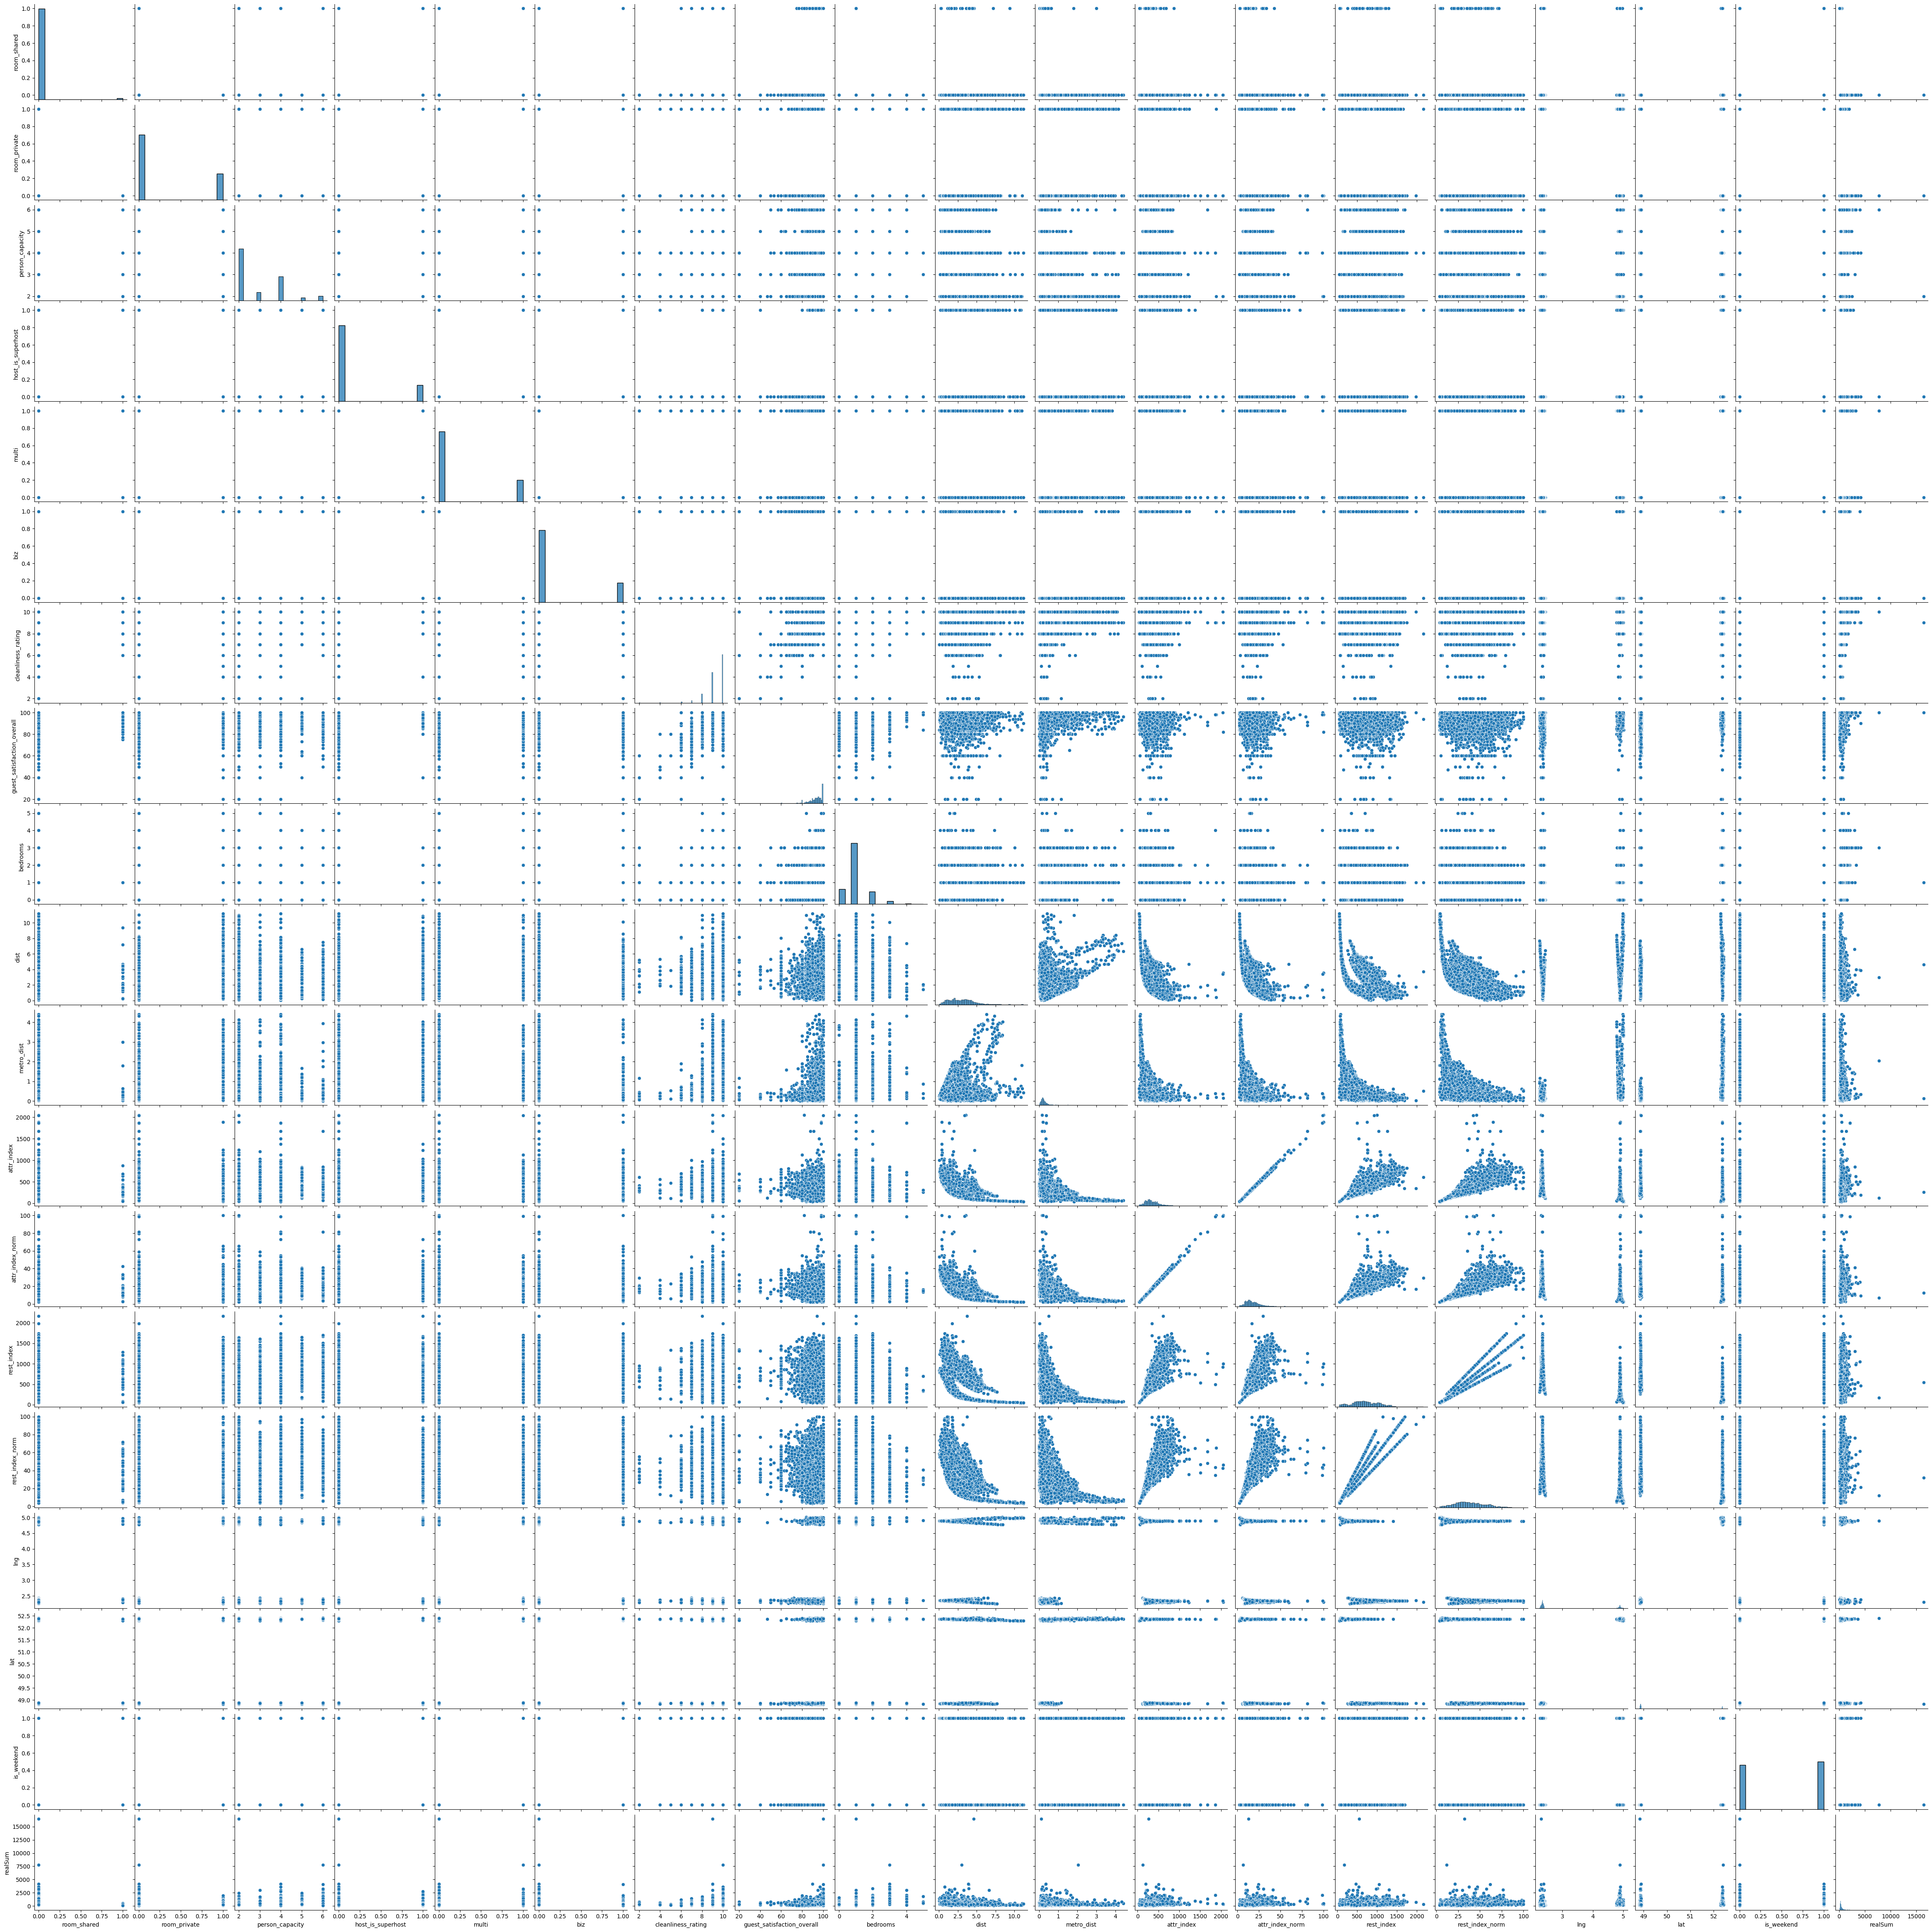

In [12]:
sns.pairplot(pd.concat([X_train, y_train], axis=1))

# Model Training and Selection

In [13]:
encoder = compose.make_column_transformer(
    (
        'scaler',
        X_train.select_dtypes('number').columns
    ),
    (
        preprocessing.OneHotEncoder(sparse_output=False, drop='first'),
        X_train.select_dtypes('category').columns
    ),
    (
        preprocessing.OneHotEncoder(sparse_output=False, drop='first'),
        X_train.select_dtypes('bool').columns
    ),
    remainder='passthrough'
)

In [14]:
model = pipeline.Pipeline([
    ('encoder', encoder),
    # ('Feature selection'),
    ('regressor', None),
])

In [15]:
parameters = [
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        "regressor": [linear_model.Ridge()],
        "regressor__alpha": [0.1, 0.5, 1.0]
    },
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        "regressor": [ensemble.RandomForestRegressor()],
        "regressor__n_estimators": [10, 50, 100],
        "regressor__min_samples_leaf": [1, 5, 10],
        "regressor__max_features": [1, 'sqrt', 'log2'],
    }
]

In [16]:
%%time
clf = model_selection.GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=1)  # Stratified by default
clf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END encoder__scaler=StandardScaler(), regressor=Ridge(), regressor__alpha=0.1;, score=-32485.654 total time=   0.0s
[CV 2/5] END encoder__scaler=StandardScaler(), regressor=Ridge(), regressor__alpha=0.1;, score=-54340.168 total time=   0.0s
[CV 3/5] END encoder__scaler=StandardScaler(), regressor=Ridge(), regressor__alpha=0.1;, score=-245014.358 total time=   0.0s
[CV 4/5] END encoder__scaler=StandardScaler(), regressor=Ridge(), regressor__alpha=0.1;, score=-60258.750 total time=   0.0s
[CV 5/5] END encoder__scaler=StandardScaler(), regressor=Ridge(), regressor__alpha=0.1;, score=-80895.279 total time=   0.0s
[CV 1/5] END encoder__scaler=StandardScaler(), regressor=Ridge(), regressor__alpha=0.5;, score=-32582.727 total time=   0.0s
[CV 2/5] END encoder__scaler=StandardScaler(), regressor=Ridge(), regressor__alpha=0.5;, score=-54360.005 total time=   0.0s
[CV 3/5] END encoder__scaler=StandardScaler(), regressor=Ridge

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         'scaler',
                                                                         Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm',
       'rest_index', 'rest_index_norm', 'lng', 'lat'],
      dtype='object')),
                                                                        ('onehotencoder-1',
                                                                         One...
             n_jobs=1,
             param_grid=[{'encoder__scaler': [StandardScaler()],
                          'regressor': [Ridge()],
                          'regressor__alpha': [0.1, 0.5, 1.0]},
                         {'encoder__scaler': [StandardScaler()],
                          'regressor': [RandomForestRegressor()],
                          'regressor__max_features': [1, 'sqrt', 'log2'],
                          'regressor__min_samples_leaf': [1, 5, 10],
                          'regressor__n_estimators': [10, 50, 100]}],
             scoring='neg_mean_squared_error', verbose=3)

In [17]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_encoder__scaler,param_regressor,param_regressor__alpha,param_regressor__max_features,param_regressor__min_samples_leaf,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013427,0.000360,0.006329,0.002184,StandardScaler(),Ridge(),0.1,NaN,NaN,NaN,"{'encoder__scaler': StandardScaler(), 'regress...",-32485.654046,-54340.168277,-245014.358234,-60258.749529,-80895.278944,-94598.841806,76773.258421,22
1,0.013026,0.000110,0.005097,0.000063,StandardScaler(),Ridge(),0.5,NaN,NaN,NaN,"{'encoder__scaler': StandardScaler(), 'regress...",-32582.726856,-54360.005481,-245294.602889,-60384.700497,-80795.839071,-94683.574959,76857.620731,23
2,0.021710,0.006630,0.008166,0.002167,StandardScaler(),Ridge(),1.0,NaN,NaN,NaN,"{'encoder__scaler': StandardScaler(), 'regress...",-32621.900006,-54305.017135,-245381.843993,-60436.114165,-80783.373000,-94705.649660,76887.124369,24
3,0.056912,0.015711,0.006111,0.000224,StandardScaler(),RandomForestRegressor(),NaN,1,1,10,"{'encoder__scaler': StandardScaler(), 'regress...",-28220.838407,-56611.060617,-244155.631227,-68198.353720,-73935.060086,-94224.188812,76602.375862,20
4,0.211132,0.001243,0.014271,0.000440,StandardScaler(),RandomForestRegressor(),NaN,1,1,50,"{'encoder__scaler': StandardScaler(), 'regress...",-26027.096434,-58203.516673,-238688.831510,-55770.147260,-74199.747948,-90577.867965,75672.423623,15
5,0.414020,0.003485,0.022464,0.000243,StandardScaler(),RandomForestRegressor(),NaN,1,1,100,"{'encoder__scaler': StandardScaler(), 'regress...",-24832.643591,-60477.976776,-238885.615569,-55626.203911,-73314.296937,-90627.347357,75819.870009,16
6,0.031184,0.000707,0.005155,0.000121,StandardScaler(),RandomForestRegressor(),NaN,1,5,10,"{'encoder__scaler': StandardScaler(), 'regress...",-34023.020780,-57836.671958,-243225.617915,-62609.282841,-85006.444444,-96540.207588,75109.662848,26
7,0.117810,0.001758,0.009323,0.000147,StandardScaler(),RandomForestRegressor(),NaN,1,5,50,"{'encoder__scaler': StandardScaler(), 'regress...",-29566.906545,-54198.614266,-243150.684815,-60404.205209,-84767.336224,-94417.549412,76413.020343,21
8,0.228931,0.003963,0.014174,0.000178,StandardScaler(),RandomForestRegressor(),NaN,1,5,100,"{'encoder__scaler': StandardScaler(), 'regress...",-29549.384858,-54483.064057,-244161.277158,-60753.237996,-85143.107118,-94818.014237,76738.940800,25
9,0.027725,0.001204,0.005022,0.000131,StandardScaler(),RandomForestRegressor(),NaN,1,10,10,"{'encoder__scaler': StandardScaler(), 'regress...",-31641.655368,-57807.405214,-246355.992310,-63410.191764,-93385.076988,-98520.064329,76478.461080,30


In [18]:
clf.best_estimator_.get_params()

{'memory': None,
 'steps': [('encoder',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('scaler', StandardScaler(),
                                    Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
          'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm',
          'rest_index', 'rest_index_norm', 'lng', 'lat'],
         dtype='object')),
                                   ('onehotencoder-1',
                                    OneHotEncoder(drop='first',
                                                  sparse_output=False),
                                    Index(['room_type', 'city'], dtype='object')),
                                   ('onehotencoder-2',
                                    OneHotEncoder(drop='first',
                                                  sparse_output=False),
                                    Index(['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz'

In [19]:
clf.best_estimator_.score(X_train, y_train)

0.5690957439121676

In [20]:
pd.DataFrame(y_train)

,realSum
5367,339.500419
5355,324.354553
5607,316.199087
5239,486.531830
4545,669.913319
...,...
1859,276.287114
7862,227.654022
6599,356.976419
1913,448.527172


In [21]:
pd.DataFrame(clf.predict(X_train))

,0
0,351.931269
1,443.611093
2,438.169283
3,540.731192
4,574.976648
...,...
6132,274.752750
6133,263.039627
6134,329.087900
6135,475.543450


In [22]:
pd.concat([pd.DataFrame(clf.predict(X_train)), y_train.reset_index(drop=True), X_train[['city', 'is_weekend']].reset_index(drop=True)], axis=1)

,0,realSum,city,is_weekend
0,351.931269,339.500419,paris,True
1,443.611093,324.354553,paris,True
2,438.169283,316.199087,paris,True
3,540.731192,486.531830,paris,True
4,574.976648,669.913319,paris,False
...,...,...,...,...
6132,274.752750,276.287114,amsterdam,True
6133,263.039627,227.654022,paris,True
6134,329.087900,356.976419,paris,True
6135,475.543450,448.527172,amsterdam,True
